# ULMFiT Sentiment Analysis - NLTK

#### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
pd.set_option('display.max_colwidth', 0)         
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
#**Adding module’s sub-directory to Pythons path**
import os
import sys
sys.path.insert(0, os.path.abspath('../helpers'))
import data

#### Data Preview

In [4]:
df_data = pd.read_csv("..\data\Tweets.csv")
df_data.sample()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
11451,568106783241211904,negative,0.6489,Customer Service Issue,0.3511,US Airways,NaN,MoamarMoMoney,NaN,0,@USAirways your agent did not say,"[41.15955496, -81.39767448]",2015-02-18 09:56:26 -0800,NaN,Eastern Time (US & Canada)


#### Data Cleaning

In [5]:
def tweet_to_words(tweet):
    """
    
    """
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) # remove URLs
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet) # remove the # in #hashtag
    tweet = re.sub("[^a-zA-Z]", " ", tweet) # Remove special characters
    tweet = tweet.lower() # convert text to lower-case
    words = word_tokenize(tweet) # remove repeated characters (helloooooooo into hello) 
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    
    return( " ".join(meaningful_words))

df_tweets = df_data.filter(items=['airline_sentiment', 'text'])
df_tweets['text'] = df_tweets['text'].apply(lambda x: tweet_to_words(x))
df_tweets

,airline_sentiment,text
0,neutral,virginamerica dhepburn said
1,positive,virginamerica plus added commercials experience tacky
2,neutral,virginamerica today must mean need take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guests faces amp little recourse
4,negative,virginamerica really big bad thing
...,...,...
14635,positive,americanair thank got different flight chicago
14636,negative,americanair leaving minutes late flight warnings communication minutes late flight called shitty customer svc
14637,neutral,americanair please bring american airlines blackberry
14638,negative,americanair money change flight answer phones suggestions make commitment


#### Data Preprocessing

In [6]:
le_model = LabelEncoder()
df_tweets['airline_sentiment'] = le_model.fit_transform(df_tweets['airline_sentiment'])
df_tweets.to_csv('..\data\Just_Tweets.csv', index=False)
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
airline_sentiment    14640 non-null int32
text                 14640 non-null object
dtypes: int32(1), object(1)
memory usage: 171.7+ KB


#### Data Test and Train Splits

In [7]:
train_data, test_data = data.create_splits(df_tweets, 'airline_sentiment')

print('Ratios in the order - positive : neutral : negative!')
pv_num = len(train_data[train_data['airline_sentiment']==2])
nn_num = len(train_data[train_data['airline_sentiment']==1])  
nv_num = len(train_data[train_data['airline_sentiment']==0]) 
print('Training ratio: {}:{}:{}'.format(pv_num/pv_num, nn_num/pv_num, nv_num/pv_num))

pv_num = len(test_data[test_data['airline_sentiment']==2])
nn_num = len(test_data[test_data['airline_sentiment']==1])
nv_num = len(test_data[test_data['airline_sentiment']==0])
print('Testing ratio: {}:{}:{}'.format(pv_num/pv_num, nn_num/pv_num, nv_num/pv_num))

Ratios in the order - positive : neutral : negative!
Training ratio: 1.0:1.0:1.0
Testing ratio: 1.0:1.0:3.0


In [8]:
train_clean_tweets=[]
for tweet in train_data['text']:
    train_clean_tweets.append(tweet)
    
test_clean_tweets=[]
for tweet in test_data['text']:
    test_clean_tweets.append(tweet)

In [9]:
vectorizer = CountVectorizer(analyzer="word")
train_features= vectorizer.fit_transform(train_clean_tweets)
test_features= vectorizer.transform(test_clean_tweets)

#### Metrics Evaluation

In [10]:
nb_model = MultinomialNB()
nb_model.fit(train_features, train_data['airline_sentiment'])

accuracy_train = accuracy_score(nb_model.predict(train_features), train_data['airline_sentiment'])
print('Training Acc. : {:.2f}'.format(accuracy_train))

Training Acc. : 0.87


In [11]:
y_pred = nb_model.predict(test_features)
y_true = test_data['airline_sentiment']
target_names = ['Negative', 'Neutral', 'Positive']

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.88      0.82      0.85      1416
     Neutral       0.57      0.57      0.57       472
    Positive       0.66      0.82      0.73       472

    accuracy                           0.77      2360
   macro avg       0.71      0.73      0.72      2360
weighted avg       0.78      0.77      0.77      2360



Text(0.5, 15.0, 'Predicted label')

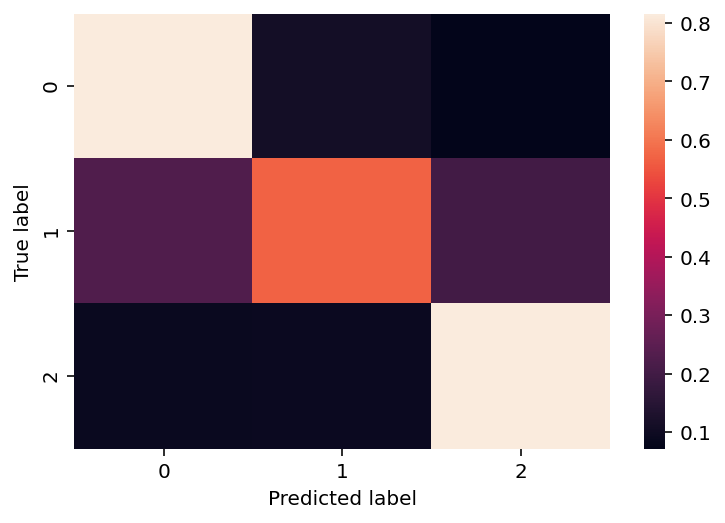

In [12]:
conf_mat = confusion_matrix(y_true, y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')